## Access Satellite Ghrsst L4 Gamssa 1Day Multi Sensor World data in Parquet
A jupyter notebook to show how to access and plot the AODN satellite_ghrsst_l4_gamssa_1day_multi_sensor_world dataset available as a [Zarr](https://zarr.dev/)  dataset on S3

In [1]:
dataset_name = "satellite_ghrsst_l4_gamssa_1day_multi_sensor_world"

In [2]:
import xarray as xr
import fsspec

## Install/Update packages and Load common functions

In [3]:
# only run once, then restart session if needed
!pip install uv

import os
import sys

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    os.system('uv pip install --system -r https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt')
else:
    os.system('uv venv')
    os.system('uv pip install -r https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt')

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 129 packages in 407ms


In [4]:
import requests
if not os.path.exists('parquet_queries.py'):
  print('Downloading parquet_queries.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/ParquetDataQuery.py'
  response = requests.get(url)
  with open('parquet_queries.py', 'w') as f:
      f.write(response.text)

In [5]:
from parquet_queries import plot_gridded_variable

In [6]:
# remote zarr dataset
url = f's3://aodn-cloud-optimised/{dataset_name}.zarr/'
ds = xr.open_zarr(fsspec.get_mapper(url, anon=True), consolidated=True)
ds

<xarray.Dataset> Size: 168GB
Dimensions:           (time: 5800, lat: 720, lon: 1440)
Coordinates:
  * lat               (lat) float32 3kB -89.88 -89.62 -89.38 ... 89.62 89.88
  * lon               (lon) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time              (time) datetime64[ns] 46kB 2008-07-23T12:00:00 ... 2024...
Data variables:
    analysed_sst      (time, lat, lon) float64 48GB dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 48GB dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    crs               int32 4B ...
    mask              (time, lat, lon) float32 24GB dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 48GB dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
Attributes: (12/64)
    Conventions:                CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Link:              https://podaac.jpl.nasa.gov/ws/metadata/datas...
    acknowledgment:             Any use of these data requires the following ...
    cdm_data_type:              Grid
    comment:                    This is a Bureau of Meteorology experimental ...
    contributor_name:           Helen Beggs
    ...                         ...
    time_coverage_end:          20240417T000000Z
    time_coverage_resolution:   P1D
    time_coverage_start:        20240416T000000Z
    title:                      GAMSSA v1.0 Analysed daily global low resolut...
    uuid:                       7a5e64af-49be-4144-909b-f1ead4370110
    westernmost_longitude:      -179.875

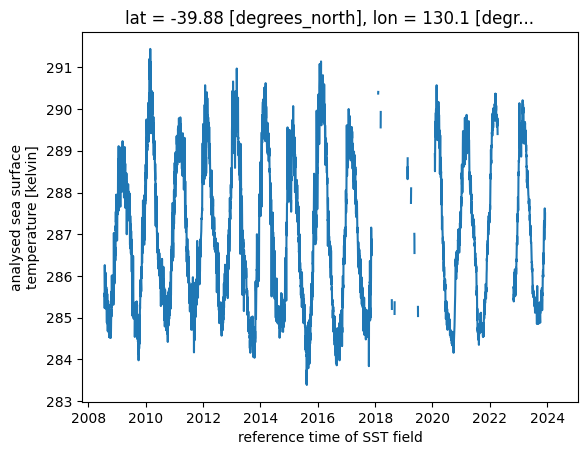

In [7]:
ds.analysed_sst.sel(lat=-40, lon=130, method='nearest').plot()

Nearest date in dataset: <xarray.DataArray 'time' ()> Size: 8B
array('2022-01-01T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2022-01-01T12:00:00
Attributes:
    axis:                   T
    comment:                Nominal time because observations are from differ...
    coverage_content_type:  coordinate
    long_name:              reference time of SST field
    standard_name:          time
Variable Long Name: analysed sea surface temperature


/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/parquet_queries.py:407: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


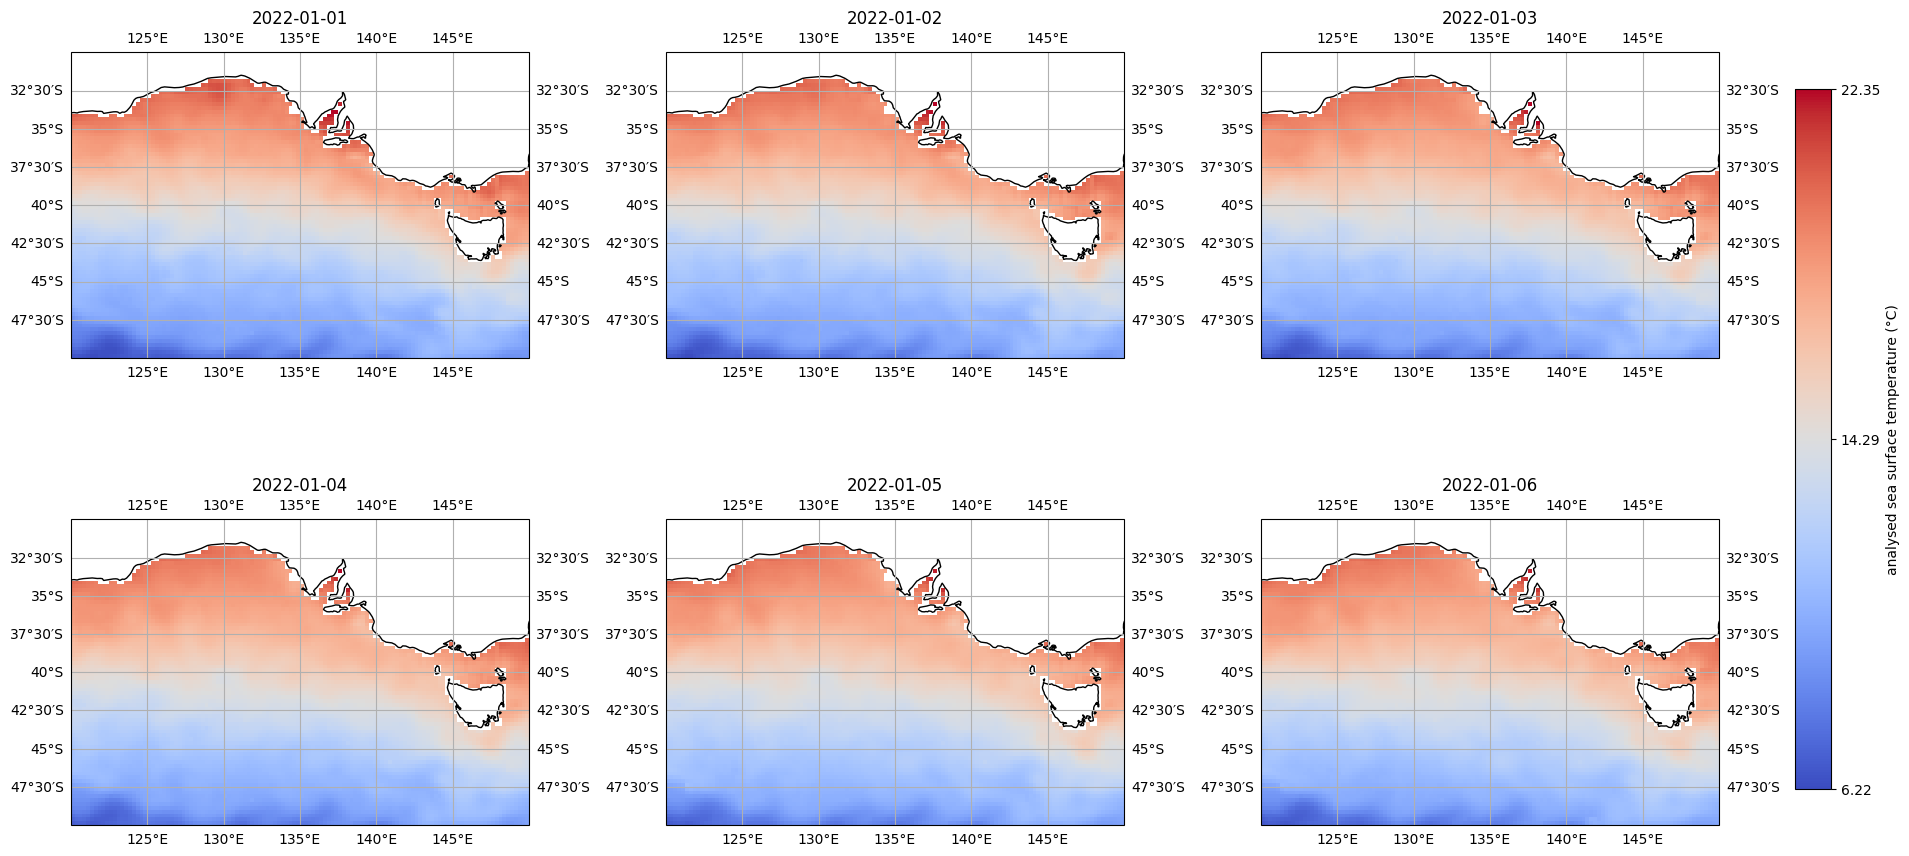

In [8]:
plot_gridded_variable(ds, start_date='2022-01-01', lon_slice=(120, 150), lat_slice=(-50, -30), var_name='analysed_sst', n_days=6, coastline_resolution="50m")

Nearest date in dataset: <xarray.DataArray 'time' ()> Size: 8B
array('2024-01-26T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2024-01-26T12:00:00
Attributes:
    axis:                   T
    comment:                Nominal time because observations are from differ...
    coverage_content_type:  coordinate
    long_name:              reference time of SST field
    standard_name:          time
Variable Long Name: sea ice area fraction


/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/parquet_queries.py:407: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


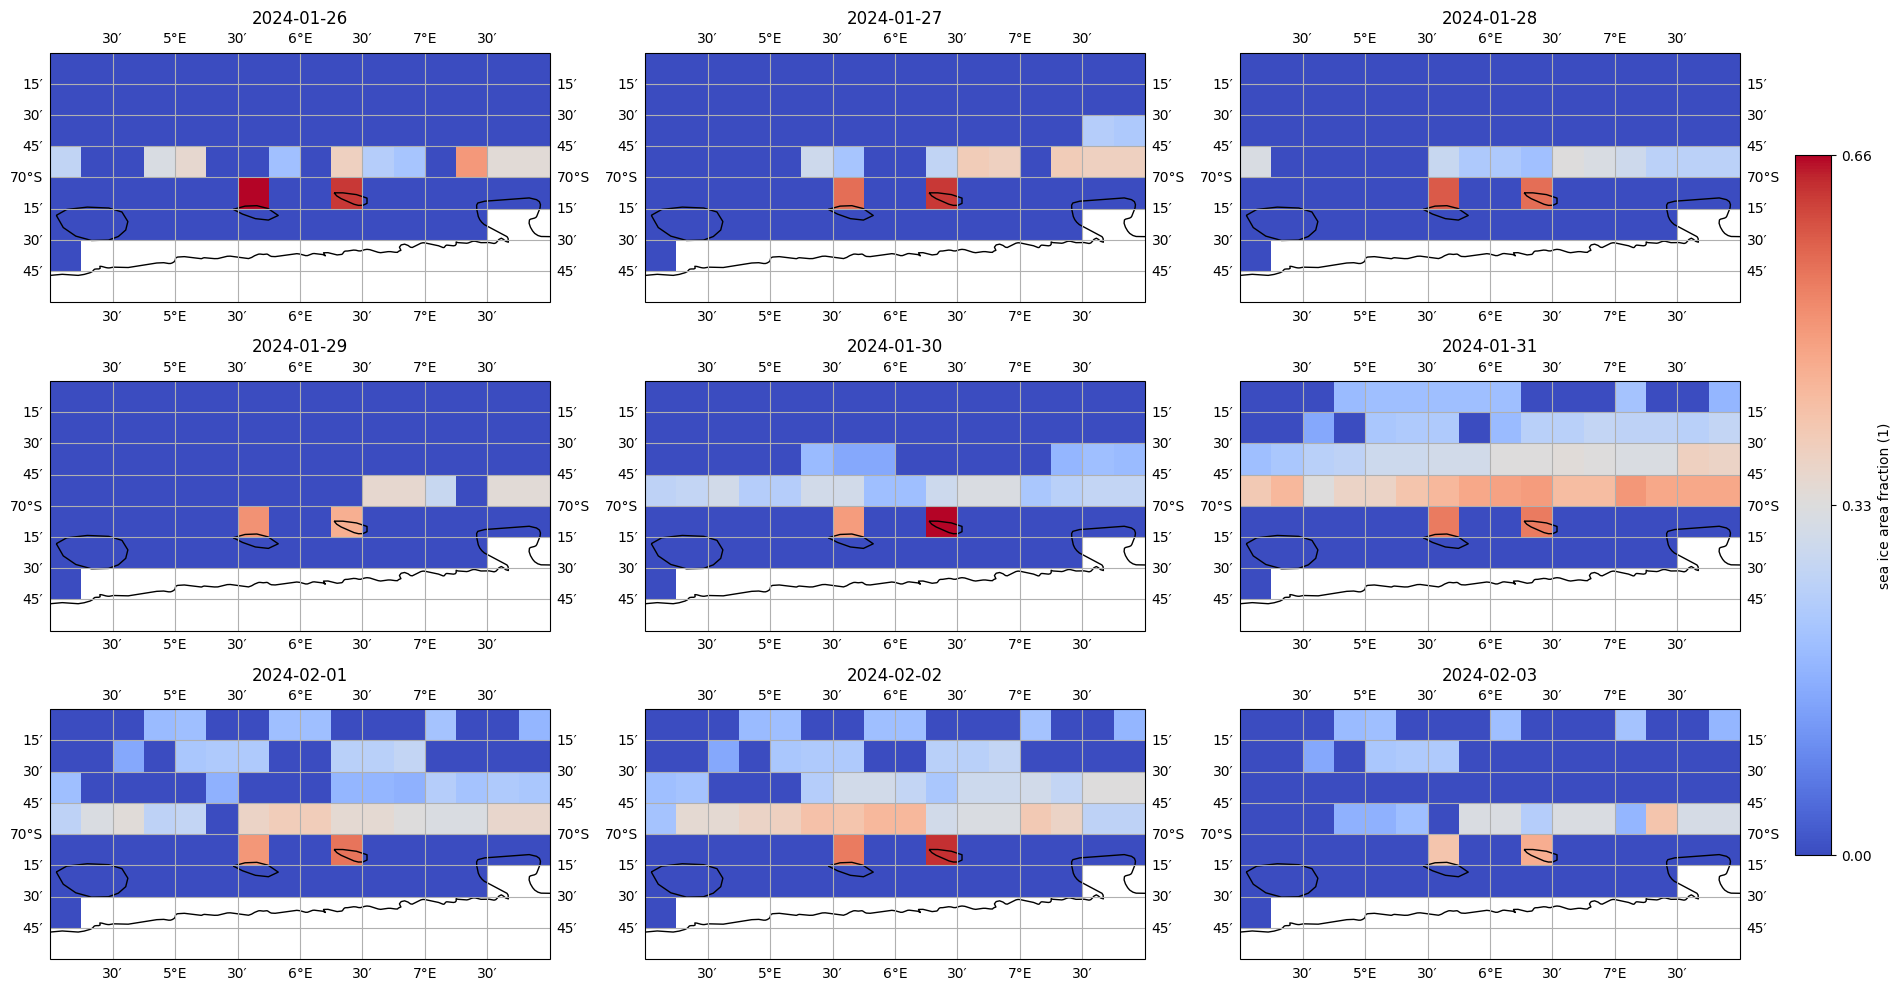

In [9]:
plot_gridded_variable(ds, start_date='2024-01-26', lon_slice=(4, 8), lat_slice=(-71, -69), var_name='sea_ice_fraction', n_days=9, coastline_resolution="10m")

In [10]:
plot_gridded_variable(ds, start_date='2022-06-01', lon_slice=(120, 150), lat_slice=(-50, -30), var_name='analysed_sst', n_days=6, coastline_resolution="50m")

Nearest date in dataset: <xarray.DataArray 'time' ()> Size: 8B
array('2022-06-01T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2022-06-01T12:00:00
Attributes:
    axis:                   T
    comment:                Nominal time because observations are from differ...
    coverage_content_type:  coordinate
    long_name:              reference time of SST field
    standard_name:          time
Variable Long Name: analysed sea surface temperature


/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/parquet_queries.py:407: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


ValueError: minvalue must be less than or equal to maxvalue

<Figure size 1800x1000 with 7 Axes>

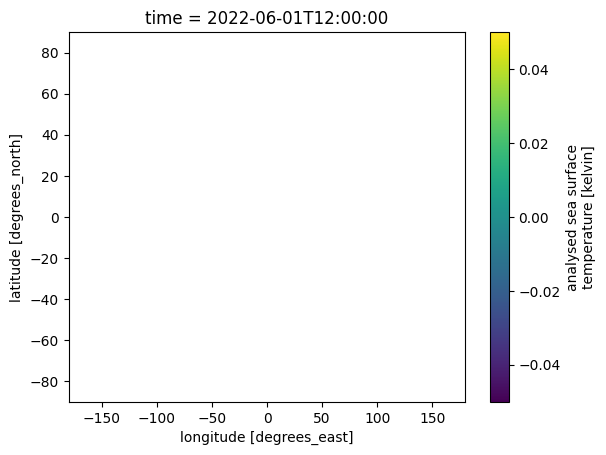

In [20]:
ds["analysed_sst"].sel(time='2022-06-01').plot()